#### Preamble

Use the environment `shrec`

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline

### Benchmark against the ARACNE Algorithm


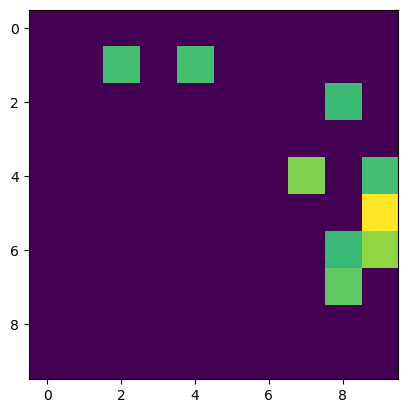

In [112]:
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler

class ARACNE:
    """
    Optimized ARACNE algorithm for inferring gene regulatory networks.

    The approach here is based on the existing open-source implementation:
    https://github.com/rugrag/ARACNE-gene-network-inference
    However, it has been modified to use vectorized operations and faster KDE
    """
    def __init__(self, n_permutations=5, random_state=None):
        self.n_permutations = n_permutations
        self.random_state = random_state
        np.random.seed(self.random_state)

    def p_kde(self, x, X, h):
        kde = gaussian_kde(X, bw_method=h)
        return kde(x)[0]

    def kernel_mi(self, X, Y):
        d = 2
        nx = len(X)
        hx = (4 / (d + 2)) ** (1 / (d + 4)) * nx ** (-1 / (d + 4))

        # Compute KDE for X, Y, and their joint distribution
        px = np.array([self.p_kde(X[i], X, hx) for i in range(nx)])
        py = np.array([self.p_kde(Y[i], Y, hx) for i in range(nx)])
        joint_data = np.vstack((X, Y))
        pxy = np.array([self.p_kde(np.array([X[i], Y[i]]), joint_data, hx) for i in range(nx)])

        # Calculate mutual information
        mi_estimation = np.log(pxy / (px * py))
        return np.mean(mi_estimation)
    
    def kernel_mi(self, X, Y):
        d = 2
        nx = len(X)
        hx = (4 / (d + 2)) ** (1 / (d + 4)) * nx ** (-1 / (d + 4))

        # Compute KDE for X, Y, and their joint distribution
        kde_X = gaussian_kde(X, bw_method=hx)
        px = kde_X(X)
        kde_Y = gaussian_kde(Y, bw_method=hx)
        py = kde_Y(Y)
        joint_data = np.array([X, Y])
        kde_joint = gaussian_kde(joint_data, bw_method=hx)
        pxy = kde_joint(joint_data)

        # Calculate mutual information
        mi_estimation = np.log(pxy / (px * py))
        return np.mean(mi_estimation)

    def calc_matMI(self, X):
        d = X.shape[1]
        matMI = np.zeros((d, d))
        for ix in np.arange(d):
            for jx in np.arange(ix+1, d):
                matMI[ix,jx] = self.kernel_mi(X[:, ix], X[:, jx])
        return matMI

    def permutation_test(self):
        matMI_perm = np.zeros((self.n_permutations, self.n_genes, self.n_genes))
        for n in range(self.n_permutations):
            shuffled_X = np.apply_along_axis(np.random.permutation, 1, self.count_matrix)
            matMI_perm[n, :, :] = self.calc_matMI(shuffled_X)
        return np.mean(matMI_perm, axis=0)

    def filter_mi(self):
        matMI_filtered = np.copy(self.matMI)
        I_0 = np.amax(self.matMI_alternative)
        matMI_filtered[matMI_filtered < I_0] = 0
        return matMI_filtered

    def data_processing_inequality(self, M, i, j, k):
        dic = {0: (i, j), 1: (i, k), 2: (j, k)}
        dpi_list = [M[i, j], M[i, k], M[j, k]]
        idx = np.argmin(dpi_list)
        return dic[idx]

    def filter_loops(self, M):
        set_to_zero = []
        for i in range(M.shape[0]):
            idx_j = np.where(M[i] != 0)[0]  # Indices where M[i] is non-zero
            for j in idx_j:
                idx_k = np.where(M[j] != 0)[0]  # Indices where M[j] is non-zero
                valid_k = idx_k[M[i, idx_k] != 0]
                if valid_k.size > 0:
                    set_to_zero.extend([self.data_processing_inequality(M, i, j, k) for k in valid_k])

        if set_to_zero:
            set_to_zero = np.array(set_to_zero).T
            M[tuple(set_to_zero)] = 0
        
        return M

    def fit_transform(self, count_matrix):
        self.count_matrix = count_matrix
        self.n_samples, self.n_genes = count_matrix.shape
        
        # Standardize the input matrix
        scaler = StandardScaler()
        count_matrix = scaler.fit_transform(count_matrix)
        
        # Calculate MI matrix
        self.matMI = self.calc_matMI(count_matrix)
        
        # Perform permutation test
        self.matMI_alternative = self.permutation_test()
        
        # Filter MI matrix
        self.matMI_filtered = self.filter_mi()
        
        # Apply Data Processing Inequality (DPI)
        self.network = self.filter_loops(self.matMI_filtered)
        
        return self.network
    
aracne = ARACNE(n_permutations=5, random_state=0)

np.random.seed(1)
X = np.random.rand(100, 10)
X0 = np.copy(X)
network = aracne.fit_transform(X)
plt.imshow(network)

In [121]:
import glob
all_datasets = sorted(glob.glob("data/combination_regulation/*"))
all_seed_vals = [int(x.split("_")[-1].split(".")[0]) for x in all_datasets]

for seed_val in all_seed_vals[-100:]:

    ## Load the dataset, the true driver, and the indices into the original regulatory network
    y_driver = np.load(f"data/combination_regulation/y_driver_{seed_val}.npy", allow_pickle=True)
    X_measure = np.load(f"data/combination_regulation/X_measure_{seed_val}.npy", allow_pickle=True)
    true_indices = np.load(f"data/combination_regulation/simplex_indices_{seed_val}.npy", allow_pickle=True)[1:]

    aracne = ARACNE(n_permutations=5, random_state=0)

    network = aracne.fit_transform(X)

    top_indices = np.argsort(np.sum(np.abs(network), axis=1))[::-1]

    # save indices to text file
    np.savetxt(f"./dump_results/aracne_output/indices_{seed_val}.txt", top_indices, fmt="%d")

    


array([4, 6])

In [115]:
# find the indices of the top value in the matrix network
top_ind = np.unravel_index(np.argmax(network, axis=None), network.shape)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.07134933, 0.        , 0.07158019,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.06941146, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.0818744 , 0.        , 0.07124266],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.10173282],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.06848928, 0.08467543],
       [0.        , 0.        , 0.       